Loading data...
Analyzing circuit characteristics...
Analyzing track evolution...
Analyzing driver performance by circuit...


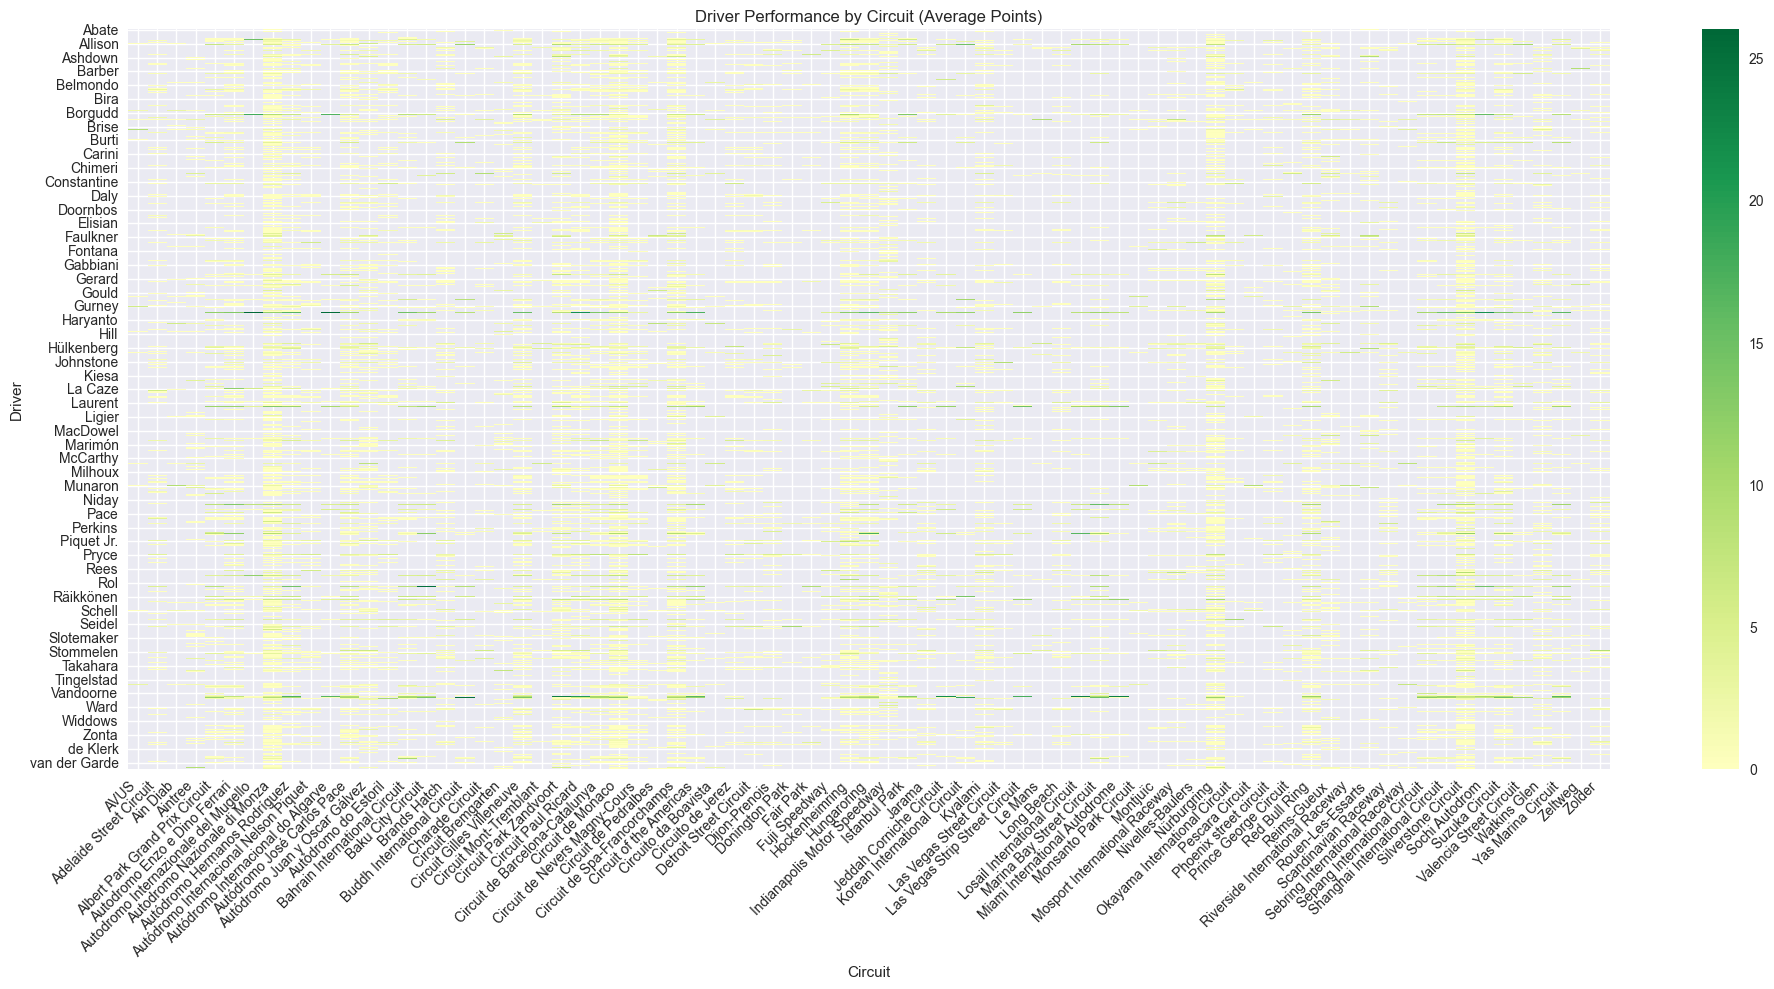

Analyzing circuit difficulty...


<Figure size 1500x800 with 0 Axes>

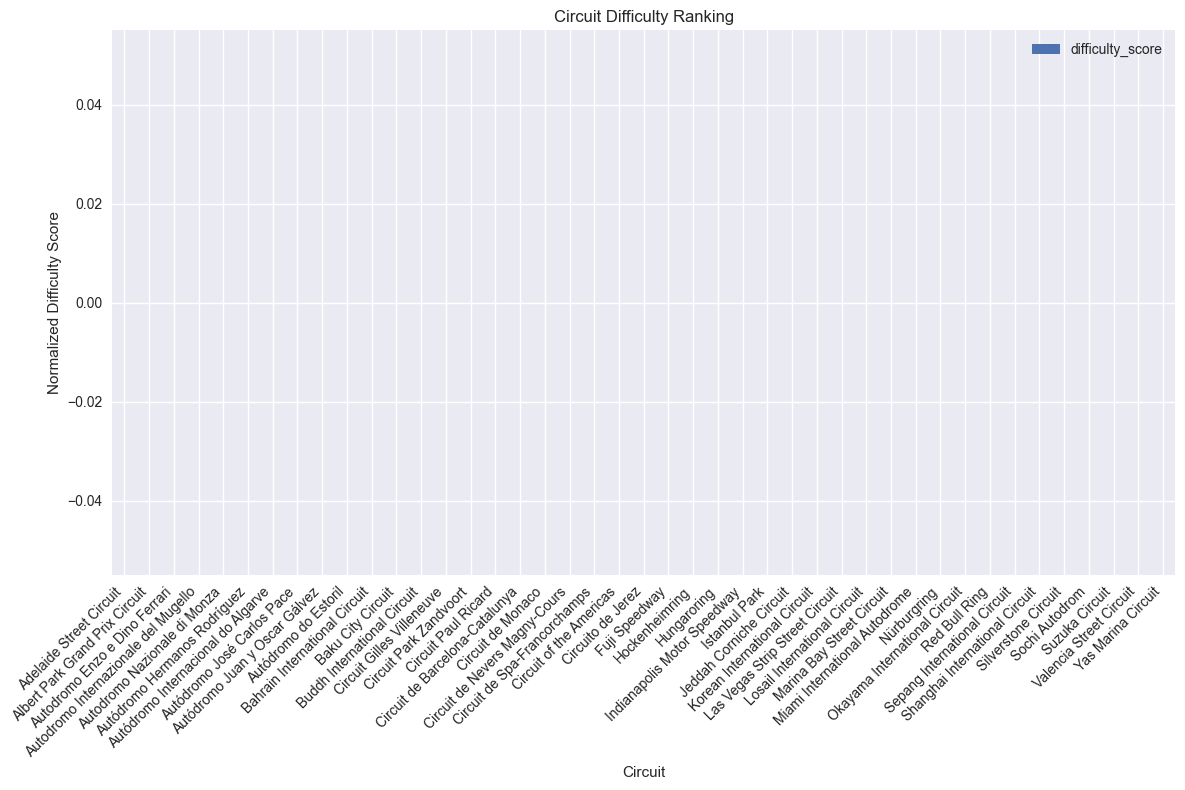


Analysis complete! Generated visualizations:
1. circuit_overtaking.png - Shows circuits with most position changes
2. track_evolution.png - Shows lap time improvements during races
3. driver_circuit_performance.png - Shows driver performance at different circuits
4. circuit_difficulty.png - Shows circuit difficulty rankings


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = [12, 8]

# Load datasets
def load_data():
    circuits = pd.read_csv('data/circuits.csv')
    races = pd.read_csv('data/races.csv')
    results = pd.read_csv('data/results.csv')
    qualifying = pd.read_csv('data/qualifying.csv')
    lap_times = pd.read_csv('data/lap_times.csv')
    drivers = pd.read_csv('data/drivers.csv')
    
    # Rename columns to avoid conflicts
    circuits = circuits.rename(columns={'name': 'circuit_name'})
    races = races.rename(columns={'name': 'race_name'})
    
    return {
        'circuits': circuits,
        'races': races,
        'results': results,
        'qualifying': qualifying,
        'lap_times': lap_times,
        'drivers': drivers
    }

# Analyze circuit characteristics
def analyze_circuit_characteristics(data):
    # First merge races with results
    race_results = pd.merge(data['races'], data['results'], on='raceId')
    
    # Then merge with circuits
    race_results = pd.merge(race_results, data['circuits'], on='circuitId')
    
    # Convert grid and position to numeric, replacing non-numeric values with NaN
    race_results['grid'] = pd.to_numeric(race_results['grid'], errors='coerce')
    race_results['position'] = pd.to_numeric(race_results['position'], errors='coerce')
    
    # Calculate position changes only for rows where both grid and position are valid numbers
    valid_mask = race_results['grid'].notna() & race_results['position'].notna()
    race_results.loc[valid_mask, 'position_changes'] = abs(
        race_results.loc[valid_mask, 'grid'] - race_results.loc[valid_mask, 'position']
    )
    
    # Calculate average position changes per circuit
    circuit_overtakes = race_results.groupby('circuit_name')['position_changes'].mean().sort_values(ascending=False)

    plt.figure(figsize=(15, 8))
    circuit_overtakes.head(15).plot(kind='bar')
    plt.title('Top 15 Circuits by Average Position Changes (2014-2023)')
    plt.xlabel('Circuit')
    plt.ylabel('Average Position Changes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('circuit_overtaking.png', bbox_inches='tight')
    plt.close()

    return circuit_overtakes

# Analyze track evolution
def analyze_track_evolution(data):
    # Merge lap times with races and circuits
    lap_data = pd.merge(
        pd.merge(data['lap_times'], data['races'][['raceId', 'circuitId', 'year']], on='raceId'),
        data['circuits'][['circuitId', 'circuit_name']], on='circuitId'
    )

    lap_data['lap_time_seconds'] = lap_data['milliseconds'] / 1000
    lap_data['stint'] = (lap_data['lap'] - 1) // 10

    stint_times = lap_data.groupby(['circuit_name', 'year', 'stint'])['lap_time_seconds'].mean().reset_index()

    plt.figure(figsize=(15, 8))
    # Plot only the top 5 most recent circuits
    recent_circuits = lap_data.sort_values('year', ascending=False)['circuit_name'].unique()[:5]
    for circuit in recent_circuits:
        circuit_data = stint_times[stint_times['circuit_name'] == circuit]
        plt.plot(circuit_data['stint'], circuit_data['lap_time_seconds'], label=circuit)

    plt.title('Track Evolution: Lap Time Improvement Throughout the Race')
    plt.xlabel('Race Progress (Stint Number)')
    plt.ylabel('Average Lap Time (seconds)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('track_evolution.png', bbox_inches='tight')
    plt.close()

# Analyze driver performance by circuit
def analyze_driver_circuit_performance(data):
    # Merge all required data
    driver_results = pd.merge(
        pd.merge(
            pd.merge(data['results'], data['races'][['raceId', 'circuitId', 'year']], on='raceId'),
            data['circuits'][['circuitId', 'circuit_name']], on='circuitId'
        ),
        data['drivers'][['driverId', 'surname']], on='driverId'
    )

    # Convert position to numeric for proper aggregation
    driver_results['position'] = pd.to_numeric(driver_results['position'], errors='coerce')
    
    # Calculate statistics
    driver_circuit_stats = driver_results.groupby(['surname', 'circuit_name']).agg({
        'points': ['mean', 'sum'],
        'position': 'mean',
        'raceId': 'count'
    }).reset_index()

    # Create pivot table for heatmap
    pivot_data = pd.pivot_table(
        driver_results,
        values='points',
        index='surname',
        columns='circuit_name',
        aggfunc='mean'
    )

    # Create heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(pivot_data, cmap='RdYlGn', center=0)
    plt.title('Driver Performance by Circuit (Average Points)')
    plt.xlabel('Circuit')
    plt.ylabel('Driver')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig('driver_circuit_performance.png', bbox_inches='tight')
    plt.show()
    plt.close()

# Analyze circuit difficulty
def analyze_circuit_difficulty(data):
    # Merge qualifying data with races and circuits
    qual_results = pd.merge(
        pd.merge(data['qualifying'], data['races'][['raceId', 'circuitId', 'year']], on='raceId'),
        data['circuits'][['circuitId', 'circuit_name']], on='circuitId'
    )

    # Convert qualifying times and position to numeric
    qual_results['q1'] = pd.to_numeric(qual_results['q1'], errors='coerce')
    qual_results['position'] = pd.to_numeric(qual_results['position'], errors='coerce')
    
    # Calculate difficulty metrics
    difficulty_metrics = qual_results.groupby('circuit_name').agg({
        'q1': ['std', 'mean'],  # Standard deviation and mean of qualifying times
        'position': ['std', 'mean']  # Standard deviation and mean of qualifying positions
    }).reset_index()

    # Flatten column names
    difficulty_metrics.columns = ['circuit_name', 'q1_std', 'q1_mean', 'pos_std', 'pos_mean']
    
    # Calculate normalized difficulty score
    difficulty_metrics['difficulty_score'] = (
        (difficulty_metrics['q1_std'] / difficulty_metrics['q1_mean']) * 
        (difficulty_metrics['pos_std'] / difficulty_metrics['pos_mean'])
    )

    # Sort and plot
    plt.figure(figsize=(15, 8))
    difficulty_metrics.sort_values('difficulty_score', ascending=True).plot(
        x='circuit_name', y='difficulty_score', kind='bar'
    )
    plt.title('Circuit Difficulty Ranking')
    plt.xlabel('Circuit')
    plt.ylabel('Normalized Difficulty Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig('circuit_difficulty.png', bbox_inches='tight')
    plt.show()
    plt.close()

    return difficulty_metrics

if __name__ == "__main__":
    print("Loading data...")
    data = load_data()
    
    print("Analyzing circuit characteristics...")
    circuit_overtakes = analyze_circuit_characteristics(data)
    
    print("Analyzing track evolution...")
    analyze_track_evolution(data)
    
    print("Analyzing driver performance by circuit...")
    analyze_driver_circuit_performance(data)
    
    print("Analyzing circuit difficulty...")
    difficulty_metrics = analyze_circuit_difficulty(data)
    
    print("\nAnalysis complete! Generated visualizations:")
    print("1. circuit_overtaking.png - Shows circuits with most position changes")
    print("2. track_evolution.png - Shows lap time improvements during races")
    print("3. driver_circuit_performance.png - Shows driver performance at different circuits")
    print("4. circuit_difficulty.png - Shows circuit difficulty rankings")
